<a href="https://colab.research.google.com/github/tanriders/Medical_Brain-Tumor-MRI-Classification-GoogLeNet/blob/main/DS_Medical_Brain_Tumor_MRI_Classification_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor MRI**

การแสดงภาพด้วยคลื่นสนามแม่เหล็ก (MRI) ที่ทำให้เป็นมาตรฐานซึ่งแสดงเนื้องอกประเภทต่างๆ ในระนาบต่างๆ ในภาพ

รูปจาก: https://www.mdpi.com/2076-3417/10/6/1999

* ระนาบตามแกน (axial plane)
* ระนาบแบ่งหน้าหลัง (coronal plane)
* ระนาบแบ่งซ้ายขวา (sagittal plane)

ข้อมูล Dataset นี้จะแบ่ง 4 ประเภทหลักๆ ได้แก่

* Glioma tumor — เนื้องอกสมองไกลโอมา
เป็นเนื้องอกสมองที่กำเนิดจาก glial cells เช่น astrocytes oliogodendrocytes และ ependymal cells ซึ่งเป็นเนื้องอกชนิดที่พบบ่อยที่สุด
* Meningioma tumor — เนื้องอกเยื่อหุ้มสมอง
เป็นเนื้องอกชนิดหนึ่งที่เกิดขึ้นในชั้นเยื่อหุ้มสมองและเยื่อหุ้มไขสันหลัง มักโตช้าและอาจใช้เวลาหลายปีกว่าผู้ป่วยจะมีอาการ จึงยากต่อการวินิจฉัย
* Pituitary tumor — เนื้องอกต่อมใต้สมอง
เป็นกลุ่มเซลล์ที่เจริญผิดปกติบริเวณต่อมใต้สมอง ซึ่งเป็นต่อมที่มีหน้าที่สร้างฮอร์โมนต่าง ๆ ในร่างกาย จึงส่งผลให้เกิดความผิดปกติในการหลั่งฮอร์โมน
* No tumor — กลุ่มคนที่ไม่เป็นเนื้องอกสมอง

Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

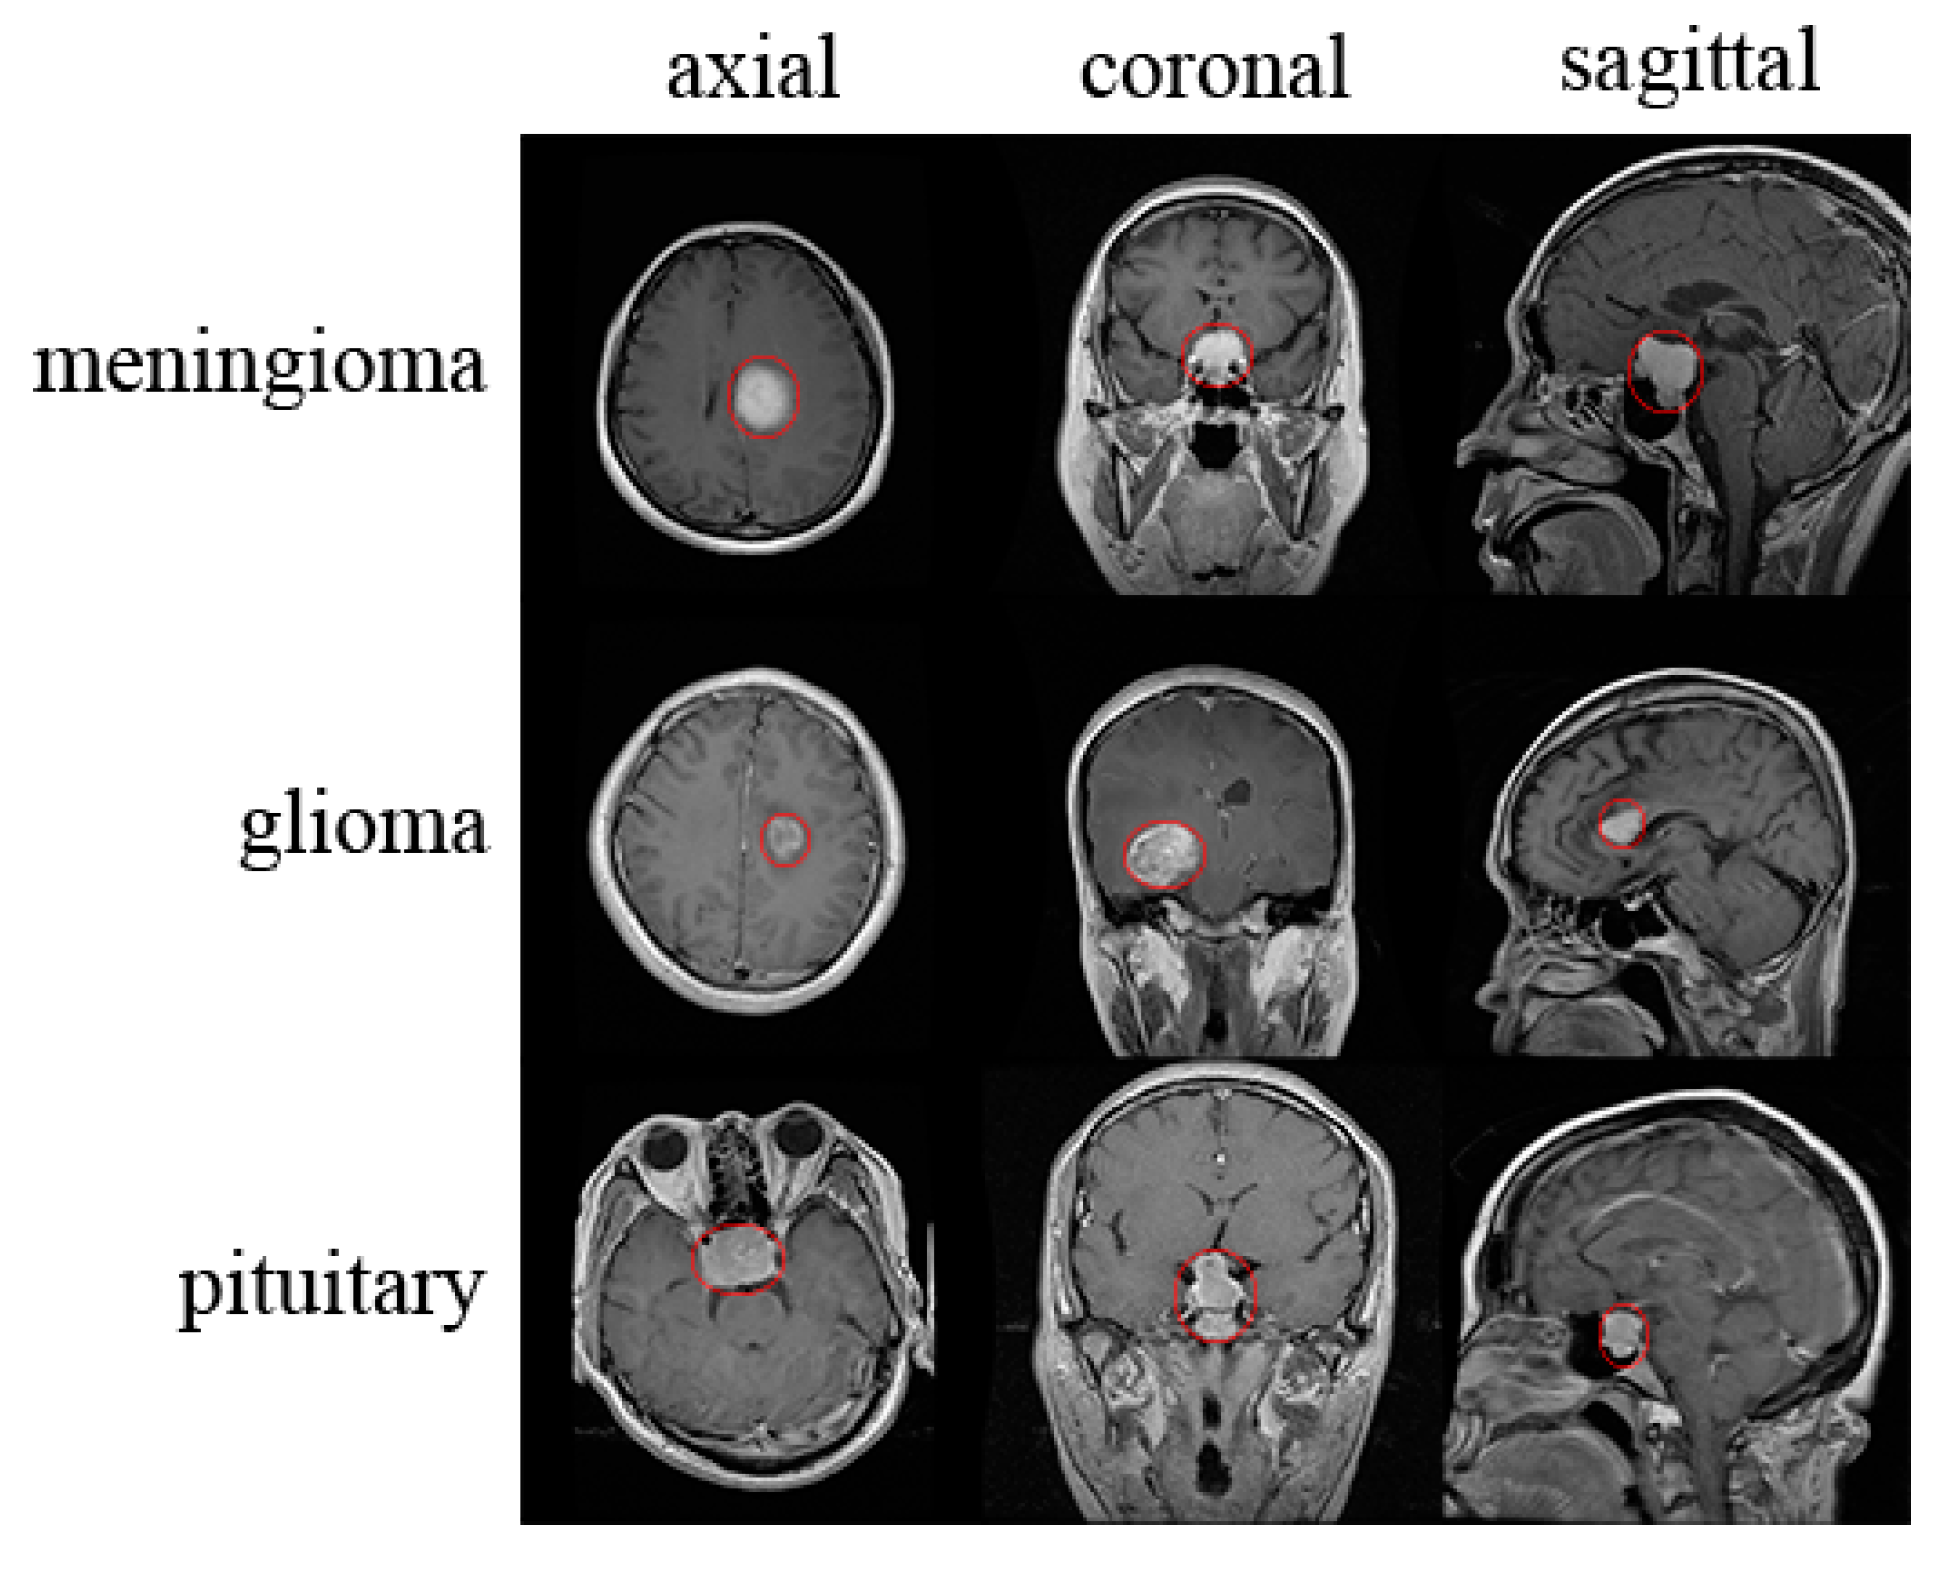

#**Importing Library**

* Install the Kaggle library

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tantanriders","key":"0f742169404e6536ee3469247fd61ec2"}'}

* Make a directory named “.kaggle”

* Copy the “kaggle.json” into this new directory

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


* Allocate the required permission for this file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

* To download the dataset into Colab we will use another command followed by the dataset name

*  For Downloading dataset

Suppose our dataset web link in  https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

* then we will type

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 97% 84.0M/86.8M [00:00<00:00, 96.1MB/s]
100% 86.8M/86.8M [00:00<00:00, 93.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-classification-mri.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Color**

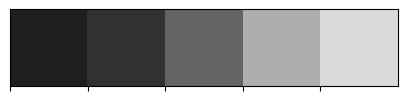

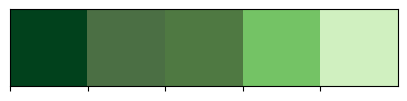

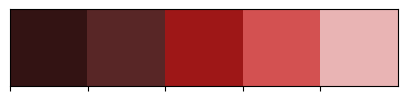

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

#**Data Preperation**

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the directories into a Python list and then converting them into numpy arrays after resizing it.

ในการจัดเตรียมข้อมูล

แปลงรูปภาพให้เป็น array ก่อนโดยใช้ library **cv2** จากนั้นทำการปรับขนาดให้เป็น 224x224 แล้วเก็บลงในตัวแปร (ในตัวข้อมูล เค้าจะแยกข้อมูล train กับ test ไว้ แต่เราจะทำการรวมเข้าด้วยกันแล้วไปแยกอีกรอบทีหลัง)

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 104.59it/s]


**ดูตัวอย่างรูปภาพแต่ละประเภท**

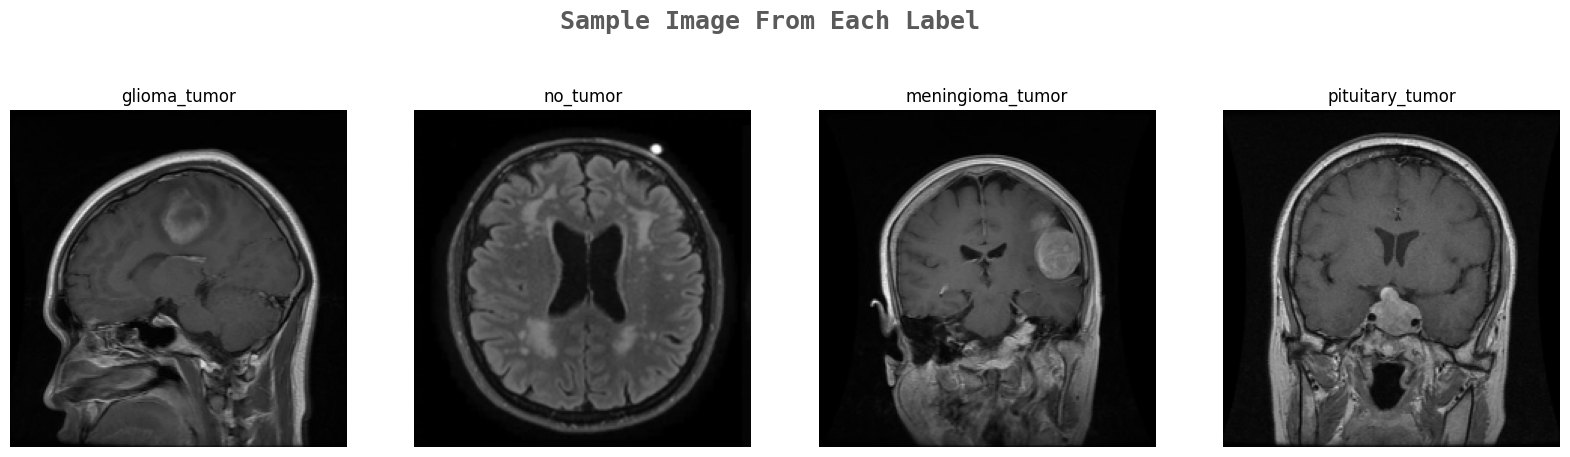

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

ทำการ shuffle ตัวข้อมูลเพื่อไม่ให้ข้อมูลมีการเรียง label กัน

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=152)

In [ ]:
X_train.shape

(3264, 224, 224, 3)

สำหรับการแบ่งข้อมูลนั้น จะแบ่งให้

* Test data 20% จากข้อมูลทั้งหมด และทำการแปลง label ให้เป็นรูปแบบ numeric



In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=156)

Performing One Hot Encoding on the labels after converting it into numerical values:

* จากนั้นทำ One Hot Encoding ซึ่งเป็นการ Encode ข้อมูล Categorical Data ที่ปกติเก็บเป็น Nominal number หรือ Ordinal number ให้แตกเป็น Column ย่อย ๆ แบบ Binary 0/1 ตาม Value ของข้อมูล

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Model**

**Transfer Learning**

ในการทำ Classification กับรูปภาพ ส่วนใหญ่จะใช้ Convolutional Neural Network (CNN) ในการทำ Deep Learning ซึ่งมีแบบเราสร้างขึ้นมาเองทั้งหมด หรือนำ pretained model มาใช้ในส่วนแรก แล้วสร้าง layer อื่นๆ ต่อท้าย

ซึ่งตัว pretained model ที่ว่านั้น ก็อย่างเช่น EfficientNet, MobileV2, Xception หรือตระกูลจำพวก Tensorflow เป็นต้น แต่เราจะใช้ Model ตัวหนึ่งที่ชื่อว่า GoogLeNet

**GoogLeNet**

GoogLeNet เป็น Convolutional Neural Network เชิงลึกที่มี Layer มากถึง 22 ชั้น โดยใช้หลักการของ Inception modules ซึ่งถูกคิดค้นและพัฒนาโดยนักวิจัยทีม Google ปัจจุบันใช้สำหรับการแก้ปัญหา Computer vision เช่น การตรวจจับใบหน้า (Face recognition) การจำแนกรูปภาพ (Image classification) การตรวจจับวัตถุ (Object detection) เป็นต้น

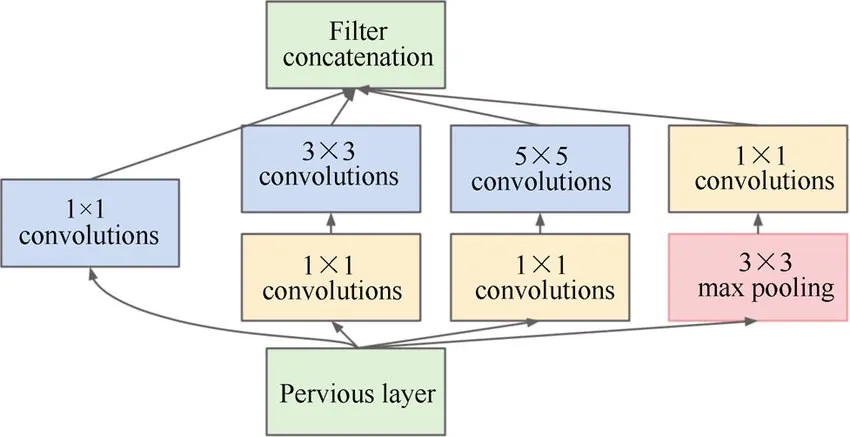

ในการเขียนโค้ดโมเดล GoogLeNet นั้น จะแบ่งเป็น 2 ฟังก์ชัน ฟังก์ชันหนึ่งไว้สำหรับทำ **Inception block** อีกฟังก์ชันหนึ่งสำหรับการทำ **GoogLeNet** ซึ่งเป็นตัวหลัก

**Inception Block function**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
    # Input:
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
     # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)
    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = Concatenate(axis = -1)([path1, path2, path3, path4])

    return output_layer

**GoogLeNet function**

In [ ]:
def GoogLeNet():
    # input layer
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)
    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32,
                      f3_conv5 = 128, f4 = 128)
    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer
    X = Dropout(0.4)(X)

    # output layer
    X = Dense(4, activation = 'softmax')(X)
     # model
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

#**Training the model**

ก่อนทำการรันโมเดล

ทำการกำหนดตัว Callbacks ซึ่งเป็นฟังก์ชันที่ช่วยดูว่าโมเดลของเราทำงานอย่างไรบ้าง ให้ผลดีขึ้นหรือไม่ เพื่อที่จะแก้ไขบัคหรือปรับปรุงโมเดลให้ดีขึ้นกว่าเดิม หรือป้องกันในกรณี Overfitting ได้ ในที่นี้จะใช้ 2 ตัวคือ

* TensorBoard

* ModelCheckpoint

In [ ]:
tensorboard_GGN = TensorBoard(log_dir = 'logs')
checkpoint_GGN = ModelCheckpoint("ggnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
# reduce_lr_GGN = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
#                               mode='auto',verbose=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

จากนั้นทำการรันโมเดลได้เลย ซึ่ง Parameter ที่กำหนดมีดังนี้

* Optimizer : Adam (Learning rate = 0.0001)
* Loss : Categorical Cross-entropy
* Epochs : 20
* Batch size : 30
* Validation : ในส่วนนี้จะมีการแบ่งข้อมูลจาก Train data เพื่อไว้สำหรับ Validation data 10%

In [ ]:
model_GGN = GoogLeNet()
model_GGN.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model_GGN.fit(X_train,y_train,validation_split=0.1, epochs = 20, verbose=1, batch_size=30,
              callbacks=[tensorboard_GGN,checkpoint_GGN])

Epoch 1/20
78/79 [============================>.] - ETA: 0s - loss: 1.3416 - accuracy: 0.3662
Epoch 1: val_accuracy improved from -inf to 0.43511, saving model to ggnet.h5
79/79 [==============================] - 27s 97ms/step - loss: 1.3405 - accuracy: 0.3674 - val_loss: 1.2171 - val_accuracy: 0.4351
Epoch 2/20
78/79 [============================>.] - ETA: 0s - loss: 1.1904 - accuracy: 0.4641
Epoch 2: val_accuracy improved from 0.43511 to 0.46565, saving model to ggnet.h5
79/79 [==============================] - 7s 89ms/step - loss: 1.1906 - accuracy: 0.4640 - val_loss: 1.1863 - val_accuracy: 0.4656
Epoch 3/20
78/79 [============================>.] - ETA: 0s - loss: 1.1226 - accuracy: 0.5107
Epoch 3: val_accuracy improved from 0.46565 to 0.55725, saving model to ggnet.h5
79/79 [==============================] - 7s 89ms/step - loss: 1.1231 - accuracy: 0.5109 - val_loss: 1.0191 - val_accuracy: 0.5573
Epoch 4/20
78/79 [============================>.] - ETA: 0s - loss: 0.9456 - accuracy: 

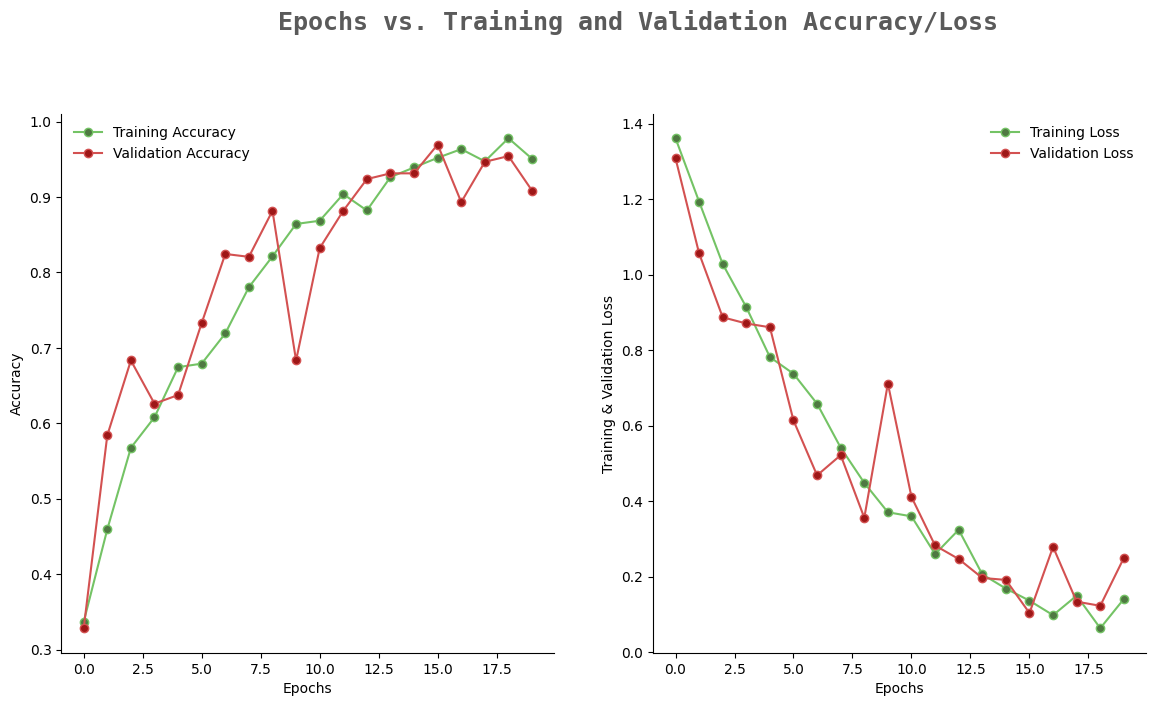

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
            label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

จากการรันโมเดล ได้ผลออกมาคือ Train data และ Validation data ให้ค่า Accuracy สูงกว่า 80% และได้ค่า Loss ต่ำกว่า 0.5 ซึ่งแสดงให้เห็นว่าโมเดลของเราทำงานได้ดีในระดับหนึ่งนั่นเอง

#**Prediction**

เมื่อเราทำการรันโมเดลเรียบร้อยแล้ว

ขั้นตอนสุดท้ายคือนำมาทำนายกับข้อมูลชุด Test ซึ่งจะใช้

* Argmax function ซึ่งเป็นฟังก์ชันที่ใช้หาตำแหน่งที่มีค่าสูงสุด (ใน Array ที่ predict ออกมาทั้ง 4 class) เพื่อให้ได้ซึ่ง class ที่ควรจะเป็นของรูปนั้นๆ นั่นเอง

In [ ]:
pred = model_GGN.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 1s 29ms/step


#**Evaluation**

In this,

0 - Glioma Tumor

1 - No Tumor

2 - Meningioma Tumor

3 - Pituitary Tumor

Classification report ของการทำโมเดลจำแนกรูปภาพ

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       188
           1       0.94      0.81      0.87       107
           2       0.96      0.78      0.86       208
           3       0.84      0.99      0.91       150

    accuracy                           0.87       653
   macro avg       0.89      0.88      0.88       653
weighted avg       0.88      0.87      0.87       653



Confusion matrix ของการทำโมเดลจำแนกรูปภาพ

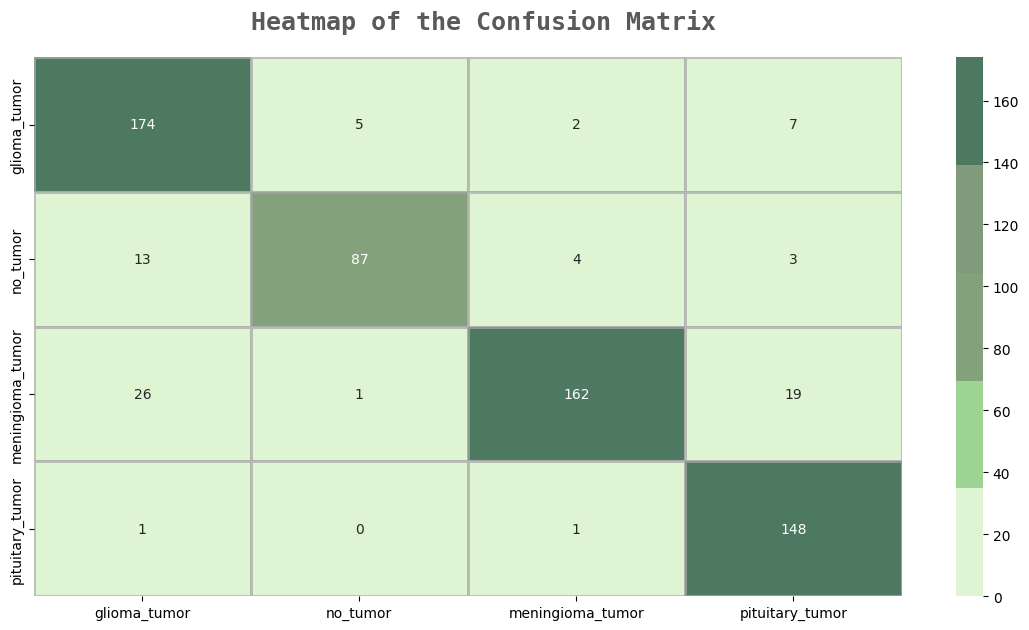

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3],fmt='d')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

**สรุป**

โมเดลนั้นสามารถจำแนกรูปภาพได้สูงถึง 87% (Accuracy)

แต่ถึงอย่างไรก็ตาม ยังมีบางส่วนที่ยังจำแนกผิด โดยเฉพาะรูปภาพประเภท Glioma tumor ที่ถูกจำแนกว่าเป็น Meningioma tumor (สังเกตจาก Confusion matrix ดังรูปข้างล่าง) คนอื่นๆ สามารถลองปรับโค้ดเพื่อให้โมเดลสามารถจำแนกรูปภาพดีขึ้นได้